## Baro Array - Coherence

### Importing

In [1]:
import os
import gc
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees
from obspy import Stream

from andbro__querrySeismoData import __querrySeismoData
from andbro__compute_coherence_stream import __coherence_stream


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Setting Variables

In [3]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

# example 1
config['tbeg'] = obspy.UTCDateTime("2024-03-16 06:00")
config['tend'] = obspy.UTCDateTime("2024-03-16 18:00")

# example 2
config['tbeg'] = obspy.UTCDateTime("2024-03-23 06:00")
config['tend'] = obspy.UTCDateTime("2024-03-23 17:00")


config['seeds'] = [
                   'BW.GELB..LDO',
                   'BW.GRMB..LDO',
                   'BW.ALFT..LDO',
                   'BW.BIB..LDO',
                   'BW.TON..LDO',
                   'BW.ROMY..LDI',
]

config['fmin'] = 0.1e-3
config['fmax'] = 0.1

config['path_to_figs'] = data_path+"/LNM2/figures/"

config['ref_station'] = 'BW.ROMY..HH*'

config['client'] = RoutingClient("eida-routing")

### Load FURT Data

In [4]:
from andbro__load_FURT_stream import __load_furt_stream

In [5]:
# furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

### Load Pressure Data

In [6]:
from andbro__read_sds import __read_sds

1 Trace(s) in Stream:
BW.GELB..LDO | 2024-03-23T06:00:00.000000Z - 2024-03-23T17:00:00.000000Z | 1.0 Hz, 39601 samples


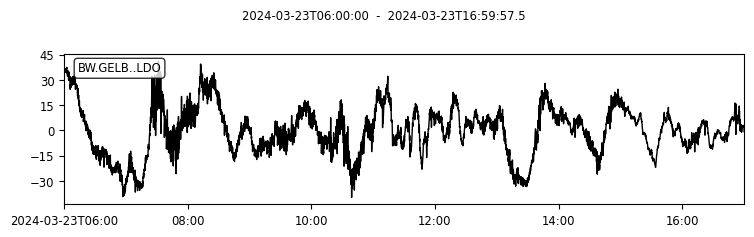

1 Trace(s) in Stream:
BW.GRMB..LDO | 2024-03-23T06:00:00.000000Z - 2024-03-23T17:00:00.000000Z | 1.0 Hz, 39601 samples


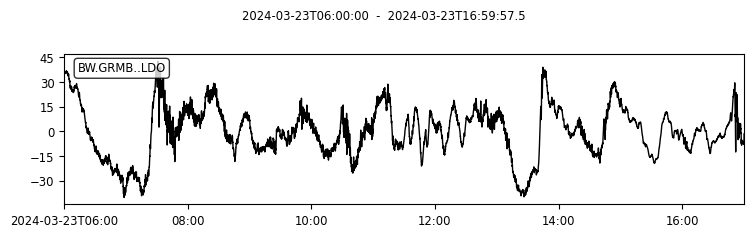

1 Trace(s) in Stream:
BW.ALFT..LDO | 2024-03-23T06:00:00.000000Z - 2024-03-23T17:00:00.000000Z | 1.0 Hz, 39601 samples


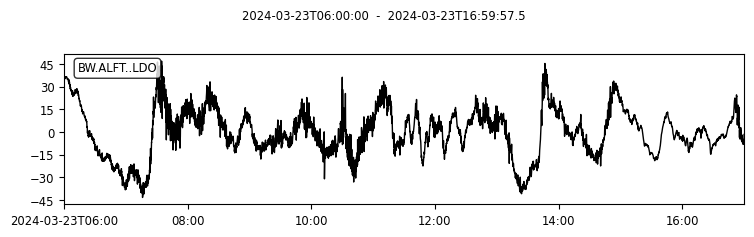

1 Trace(s) in Stream:
BW.BIB..LDO | 2024-03-23T06:00:00.000000Z - 2024-03-23T17:00:00.000000Z | 1.0 Hz, 39601 samples


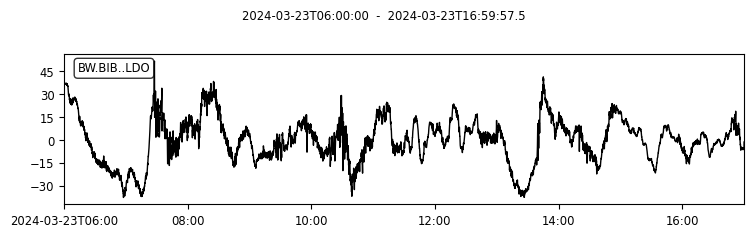

1 Trace(s) in Stream:
BW.TON..LDO | 2024-03-23T06:00:00.000000Z - 2024-03-23T17:00:00.000000Z | 1.0 Hz, 39601 samples


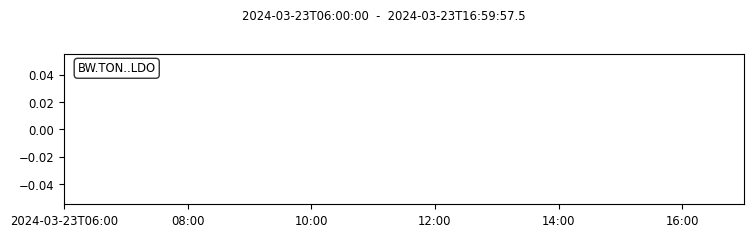

1 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-03-23T06:00:00.000000Z - 2024-03-23T17:00:00.000000Z | 1.0 Hz, 39601 samples


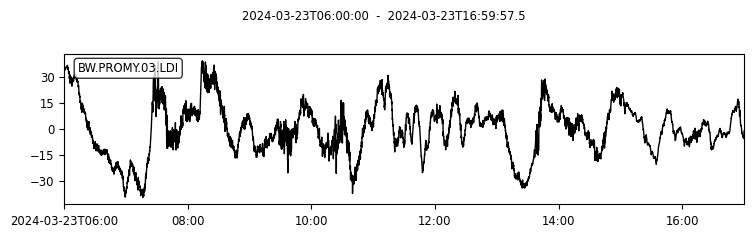

In [7]:
df_pressure = pd.DataFrame()

st = Stream()

for _i, seed in enumerate(config['seeds']):

    if "ROMY" in seed:
        seed = "BW.PROMY.03.LDI"

    ps = __read_sds(archive_path+"temp_archive/", seed, config['tbeg'], config['tend'])
    print(ps)

    try:
        # convert from Pa to hPa
        if "ROMY" in seed:
            ps[0].data = ps[0].data / 100

        ps = ps.detrend("simple")

        ps = ps.taper(0.01, type="cosine")

        ps = ps.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

        ps = ps.resample(config['fmax']*4)

        # convert from hPa to Pa
        ps[0].data = ps[0].data * 100

        if _i == 0:
            df_pressure["time"] = ps[0].times(reftime=config['tbeg'])

        df_pressure[f"{seed.split('.')[0]}.{seed.split('.')[1]}"] = ps[0].data

        ps.plot();

        st += ps

    except:
        print(f"Error: {seed}")



### Compute Coherence

In [8]:
twin = 2.5/config['fmin'] # seconds
print(twin)


nseg = st[0].stats.sampling_rate*twin
nover = 0.5*nseg

ff, coh = __coherence_stream(st, st.select(station="PROMY")[0], nseg=nseg, nover=nover)


25000.0


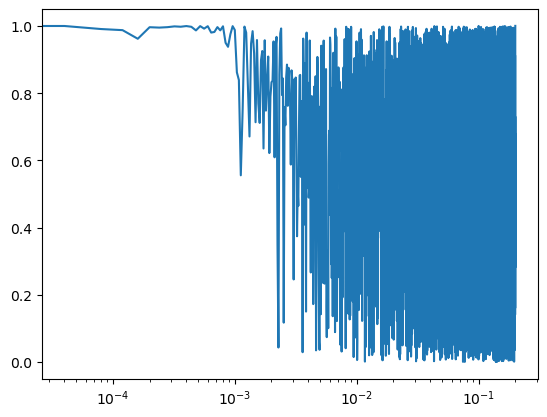

In [9]:
plt.semilogx(ff[0], coh[0])

### Compute Fband Averages

In [10]:
from functions.get_fband_average import __get_fband_average

In [11]:
ff_avg, coh_avg = [], []

for _f, _coh in zip(ff, coh):
    out = __get_fband_average(_f,
                              _coh,
                              faction_of_octave=6,
                              fmin=config['fmin'],
                              fmax=config['fmax'],
                              average='mean',
                              )

    ff_avg.append(out['fcenter'])
    coh_avg.append(out['psd_means'])


/home/andbro/notebooks/RomyArray/functions/get_fband_average.py:42: RuntimeWarning: Mean of empty slice
  psd_average.append(nanmean(psd[ifl:ifu]))


### Plotting

In [12]:
def __makeplot_coherence(st_in, ff, coh, ref, twin=None):


    st_ref = st_in.select(station=ref)

    NN = 2

    font = 14

    if st_ref[0].stats.npts*st_ref[0].stats.delta > 10000:
        time_scaling, time_unit = 1/3600, "hour"
    else:
        time_scaling, time_unit = 1/60, "min"

    fig, ax = plt.subplots(NN, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 3]})

    ax[0].plot(st_ref[0].times()*time_scaling, st_ref[0].data, color="k", label=st_ref[0].stats.station+"."+st_ref[0].stats.channel, zorder=2)

    for tr in st_in:
        ax[0].plot(tr.times()*time_scaling, tr.data, color="grey", alpha=0.5, zorder=1)


    for f, c, tr in zip(ff, coh, st_in):
        if tr.stats.station == ref:
            ax[1].plot(f, c, color="k", zorder=0, ls="-.", label=tr.stats.station+"."+tr.stats.channel)
        else:
            ax[1].plot(f, c, label=tr.stats.station+"."+tr.stats.channel, alpha=0.8)

    ax[0].legend(fontsize=font-2)
    ax[1].legend(fontsize=font-2)

    ax[1].set_xscale("log")

    ax[1].set_xlim(config['fmin'], config['fmax'])

    ax[1].grid(ls=":", color="grey", zorder=-1, which="both")

    ax[0].set_title(f"Coherence (f = {config['fmin']}-{config['fmax']}Hz | window = {twin}s)",fontsize=font+1, pad=10)
    ax[0].set_ylabel(f"norm. Amp. \n (m/s)", fontsize=font)
    ax[0].set_xlabel(f"Time ({time_unit})", fontsize=font)
    ax[1].set_ylabel(f"Coherence", fontsize=font)
    ax[1].set_xlabel(f"Frequency (Hz)", fontsize=font)

    ax[1].set_ylim(0, 1.05)

    plt.show();
    return fig

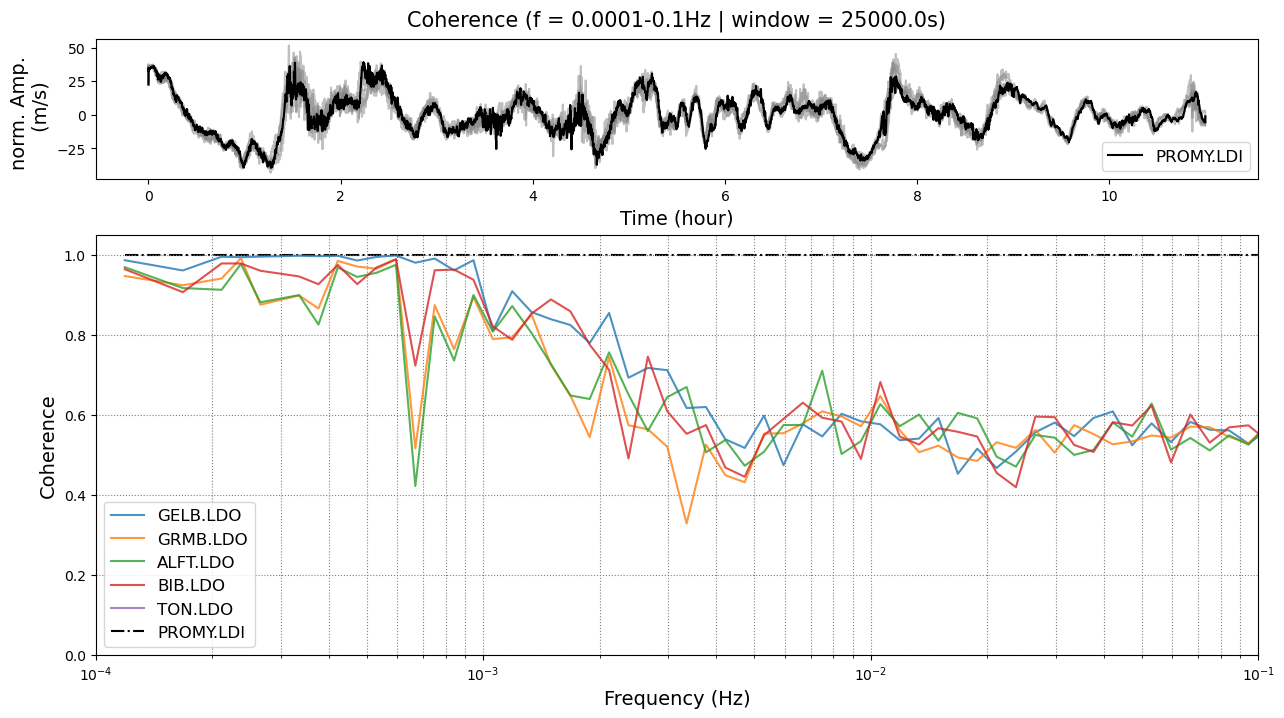

In [13]:
fig = __makeplot_coherence(st, ff_avg, coh_avg, "PROMY", twin=twin)

